In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycuda.autoinit
import warnings
import time
import cpuinfo
import os
from pycuda.tools import make_default_context
from pycuda import driver, compiler, tools, gpuarray
warnings.filterwarnings('ignore')

In [104]:
def MATRIX_MULTIPLICATION_GPU(matrix_a, matrix_b, matrix_dimension, bdim, gdim):
    kernel = '''
    __global__ void MatrixMulKernel(float *a, float *b, float *c, const int DIMENSION){
        int COLUMN = threadIdx.x + blockIdx.x * blockDim.x;
        int ROW =  threadIdx.y + blockIdx.y * blockDim.y;
        for(int i = 0; i < DIMENSION; i++){
            c[COLUMN + ROW * DIMENSION] += a[i + ROW * DIMENSION] * b[COLUMN + i * DIMENSION];
        }       
}
'''
    matrix_c = gpuarray.empty((matrix_dimension, matrix_dimension), np.float32)
    matrixmul = compiler.SourceModule(kernel).get_function('MatrixMulKernel')
    matrixmul(matrix_a, matrix_b, matrix_c, matrix_dimension, block=bdim, grid=gdim)
    return matrix_c.get()

In [105]:
def MATRIX_MULTIPLICATION_CPU(matrix_a, matrix_b):
    matrix_c = np.zeros(shape=(matrix_a.shape[0], matrix_b.shape[1]), dtype=np.float32)
    for i in range(len(matrix_a)):
        for j in range(len(matrix_b)):
            for k in range(len(matrix_b)):
                matrix_c[i][j] += matrix_a[i][k] * matrix_b[k][j]
    return matrix_c

In [106]:
DIMENSIONS = [32, 64, 128, 256, 512]
TIME_CPU = []
TIME_GPU = []
DIFFERENCE_CPU_GPU = []

print(f'GPU: {tools.make_default_context().get_device().name()}')
print(f'CPU: {cpuinfo.get_cpu_info()["brand_raw"]}')
print()

for size in DIMENSIONS:
    # Создаём данные
    matrix_a = np.random.randn(size, size).astype(np.float32)
    matrix_b = np.random.randn(size, size).astype(np.float32)
    matrix_c = matrix_a @ matrix_b  # Для проверки перемножения))
    
    # Вычисляем время на CPU
    CPU_START = time.time()
    CPU = MATRIX_MULTIPLICATION_CPU(matrix_a, matrix_b)
    CPU_TIME = time.time() - CPU_START
    TIME_CPU.append(CPU_TIME)
    
    # Вычисляем время на GPU
    GPU_START = time.time()
    if size > 32:
        gdim, remains = divmod(size, 32)
        bdim = (32,32,1)
        gdim = (gdim + (remains > 0), gdim + (remains > 0))
    else:
        bdim = (size, size, 1)
        gdim = (1,1)
    matrix_a_gpu = gpuarray.to_gpu(matrix_a)
    matrix_b_gpu = gpuarray.to_gpu(matrix_b)
    GPU = MATRIX_MULTIPLICATION_GPU(matrix_a_gpu, matrix_b_gpu, np.int32(size), bdim, gdim)
    GPU_TIME = time.time() - GPU_START
    TIME_GPU.append(GPU_TIME)

    # Проверим разницу в перемножении с эталоном
    DIFF_CPU = np.max(np.abs(CPU - matrix_c))
    DIFF_GPU = np.max(np.abs(GPU - matrix_c))
    MULT_DIFFERENCE = np.max([DIFF_CPU, DIFF_GPU])
    
    # Вычисляем разницу между CPU & GPU
    DIFFERENCE_TIME = CPU_TIME - GPU_TIME
    DIFFERENCE_CPU_GPU.append(DIFFERENCE_TIME)
    
    print(f'Размерность матрицы: {size}')
    print(f'Время выполнения на CPU: {CPU_TIME:.3f}')
    print(f'Время выполнения на GPU: {GPU_TIME:.3f}')
    print(f'Разница между CPU & GPU: {DIFFERENCE_TIME:.3f}')
    print(f'Разница в перемножении в сравнении с эталоннным перемножением: {MULT_DIFFERENCE:.3f}')
    print()

GPU: Tesla P100-PCIE-16GB
CPU: Intel(R) Xeon(R) CPU @ 2.00GHz

Размерность матрицы: 32
Время выполнения на CPU: 0.026
Время выполнения на GPU: 0.003
Разница между CPU & GPU: 0.023
Разница в перемножении в сравнении с эталоннным перемножением: 0.000

Размерность матрицы: 64
Время выполнения на CPU: 0.207
Время выполнения на GPU: 0.002
Разница между CPU & GPU: 0.205
Разница в перемножении в сравнении с эталоннным перемножением: 0.000

Размерность матрицы: 128
Время выполнения на CPU: 1.781
Время выполнения на GPU: 0.002
Разница между CPU & GPU: 1.779
Разница в перемножении в сравнении с эталоннным перемножением: 0.000

Размерность матрицы: 256
Время выполнения на CPU: 13.373
Время выполнения на GPU: 0.003
Разница между CPU & GPU: 13.371
Разница в перемножении в сравнении с эталоннным перемножением: 0.000

Размерность матрицы: 512
Время выполнения на CPU: 112.735
Время выполнения на GPU: 0.005
Разница между CPU & GPU: 112.730
Разница в перемножении в сравнении с эталоннным перемножением: 

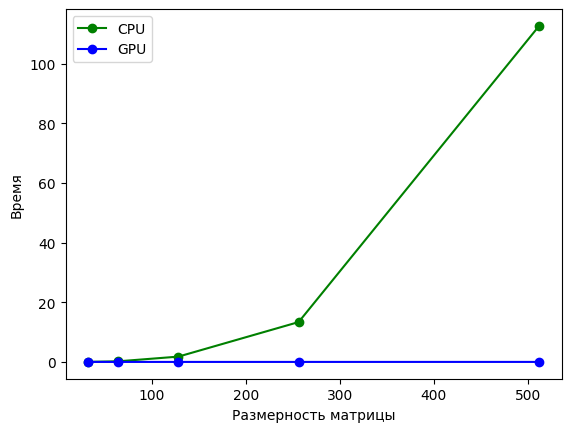

In [107]:
plt.plot(DIMENSIONS, TIME_CPU, color='green', label='CPU', marker='o')
plt.plot(DIMENSIONS, TIME_GPU, color='blue', label='GPU', marker='o')
plt.xlabel('Размерность матрицы')
plt.ylabel('Время')
plt.legend()